## Imports

In [ ]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 21.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=68b39d14453a535957f2acacd797d3517c3e4870799707cb666afc475aa847ec
  Stored in directory: /root/.cache/pip/wheels/90/61/ec/9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=3e8a0d96ff4b199a98dc6e187c597e8b6e17632c087e8d8470aaaca254b39a70
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built pyLDAvis sklearn


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
import numpy as np
import nltk
import pickle
import pyLDAvis.sklearn
from collections import Counter
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import re
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
porter = PorterStemmer()
import string

from textblob import TextBlob
from os import path
import nltk
nltk.download('punkt')
import pandas as pd

Mounted at /content/gdrive


/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable
/usr/local/lib/python3.8/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df = pd.read_csv("gdrive/My Drive/Colab Notebooks/SBIC.v2.agg.trn.csv")
df

,Unnamed: 0,post,targetMinority,targetCategory,targetStereotype,whoTarget,intentYN,sexYN,offensiveYN,dataSource,hasBiasedImplication
0,0,"\n\nBill Kristol and Ben Shaprio, two turds in...",[],[],[],0.0,0.886667,0.0,1.000000,Gab,1
1,1,\n\nRose\n🌹Taylor‏ @RealRoseTaylor 6h6 hours a...,[],[],[],NaN,0.220000,0.0,0.000000,Gab,1
2,2,\nCharlie Kirk‏\n\nJohnny Depp calls for death...,"[""liberals""]","[""social""]","[""miscontrue things"", ""take things in a weird ...",1.0,1.000000,0.0,1.000000,Gab,0
3,3,\nDavid Knight‏ \n\nNotice how quickly things ...,[],[],[],0.0,0.110000,0.0,0.166667,Gab,1
4,4,\nFinland fireball: Time-lapse video shows nig...,[],[],[],NaN,0.000000,0.0,0.000000,Gab,1
...,...,...,...,...,...,...,...,...,...,...,...
35419,35498,👉 Illegally in the country after 5 deportation...,[],[],[],NaN,0.220000,0.0,0.000000,Gab,1
35420,35500,💥Breaking💥\nJulian Assange is the gate keeper ...,[],[],[],0.0,0.000000,0.0,0.000000,Gab,1
35421,35501,📖 2Kings 22:19 because your heart was peniten...,[],[],[],NaN,0.000000,0.0,0.000000,Gab,1
35422,35502,🚨#FAKENEWSAWARDS🚨\n\n🚨 who is #1 fake news ?🚨\...,[],[],[],0.0,0.553333,0.0,0.500000,Gab,1


## Pre-Processing

#### Check for null values

In [ ]:
df['post'].isnull().sum()

0

In [ ]:
# remove punctations
df['p']=df['post'].str.replace('"', '')
df['p'] = df['p'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))
df['p'] = df['p'].apply(lambda elem: re.sub(r"\d+", "", elem))

#### Clean, Remove Stop Words, Punctuations, lemmatize

In [ ]:
def preprocess_txt(data):

  data = word_tokenize(data)
  data = [x.lower() for x in data]
  data = [re.sub('[0-9]+', '', x) for x in data]
  data = [porter.stem(word) for word in data]
  data = [w for w in data if not w in STOP_WORDS]
  data = list(filter(lambda token: token not in (str.maketrans('', '', string.punctuation)), data))
  data = [x for x in data if len(x) > 1]
  data = [x for x in data if ' ' not in x]

  return data

In [ ]:
df['clean_post'] = df['p'].apply(preprocess_txt)

## EDA

#### Sentiment polarity check with TextBlob

#### When a sentence is passed into Textblob it gives two outputs, which are polarity and subjectivity. Polarity is the output that lies between [-1,1], where -1 refers to negative sentiment and +1 refers to positive sentiment.

In [ ]:
df['lemma_clean_str'] = [' '.join(map(str,l)) for l in df['clean_post']]
df['sentiment'] = df['lemma_clean_str'].apply(lambda x: TextBlob(x).sentiment.polarity)

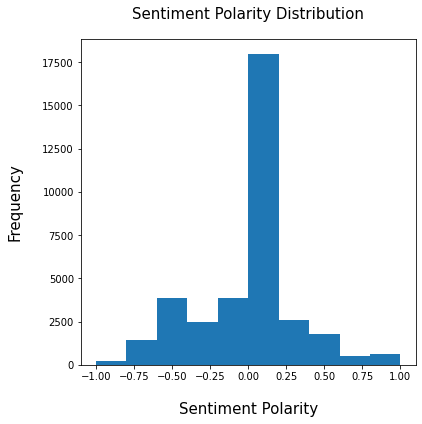

In [ ]:
plt.figure(figsize=(6,6))
plt.margins(0.05)
plt.xlabel('Sentiment Polarity', fontsize =15, labelpad=20)
plt.ylabel('Frequency', fontsize =15, labelpad=20)
plt.hist(df['sentiment'], bins=10)
plt.title('Sentiment Polarity Distribution', fontsize =15, pad=20)
plt.savefig('gdrive/My Drive/Colab Notebooks/1.png')
plt.show()


#### Findings_1: 

* Graph shows a combination of neatives, positives and neutral posts wherein most of them are netural and negatives

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


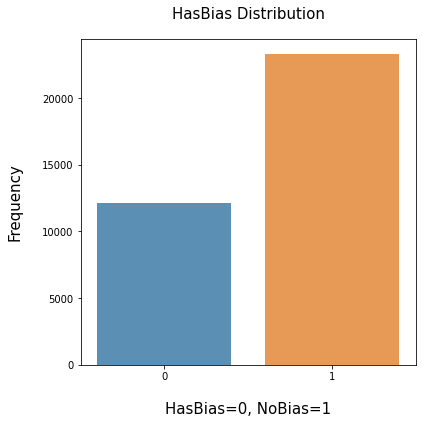

In [ ]:
plt.figure(figsize=(6,6))
x_bias = df.hasBiasedImplication.value_counts()
y_bias = x_bias.sort_index()
sns.barplot(x_bias.index, x_bias.values, alpha=0.8)
plt.title("HasBias Distribution", fontsize =15, pad=20)
plt.ylabel('Frequency', fontsize =15, labelpad=20)
plt.xlabel('HasBias=0, NoBias=1', fontsize =15, labelpad=20)
plt.show()

#### Findings_2:

* Graph Shows that there are almost ~12-13k posts are Offensive and has bias in them

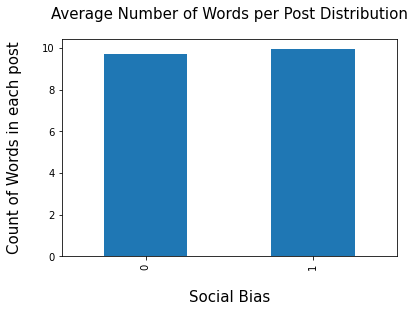

In [ ]:
# count the number of words in each post
df['words_cnt'] = df['lemma_clean_str'].apply(lambda x: len(str(x).split()))

word_avg = df.groupby('hasBiasedImplication')['words_cnt'].mean().plot(kind='bar')
plt.xlabel('Social Bias', fontsize =15, labelpad=20)
plt.ylabel('Count of Words in each post', fontsize =15, labelpad=20)
plt.title('Average Number of Words per Post Distribution', fontsize =15, pad=20)
plt.show()

#### Findings_3:

* Graph shows that most of post has 10-11 words

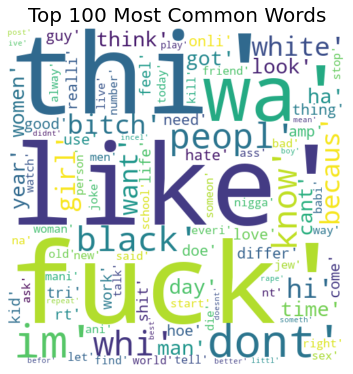

In [ ]:
import itertools


word = df['lemma_clean_str']
words = []
my_word_arr = []
a = []
for wordlist in word:
    my_word_arr.append(wordlist.split(' '))

for arr in my_word_arr:
  ab = itertools.chain(arr)
  a += ab

mostcmn = FreqDist(a).most_common(100)
wordcloud = WordCloud(width=500, height=500, background_color='white').generate(str(mostcmn))
fig = plt.figure(figsize=(5,5), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=20)
plt.tight_layout(pad=0)
plt.show()

#### Findings_4:

* Most used words are like, fuck, black, know, hate in our database

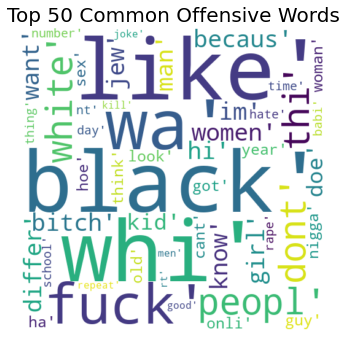

In [ ]:
Not_Offensive = df[df['offensiveYN'] == 0]
Offensive = df[df['offensiveYN'] == 1]

word = Offensive['lemma_clean_str']
words = []
my_word_arr = []
a = []
for wordlist in word:
    my_word_arr.append(wordlist.split(' '))

for arr in my_word_arr:
  ab = itertools.chain(arr)
  a += ab

mostcmn = FreqDist(a).most_common(50)
wordcloud = WordCloud(width=500, height=500, background_color='white').generate(str(mostcmn))
fig = plt.figure(figsize=(5,5), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 50 Common Offensive Words', fontsize=20)
plt.tight_layout(pad=0)
plt.show()

#### Findings_5:

* Most common used offensive words are fuck, black, bitch, women, jew in our database

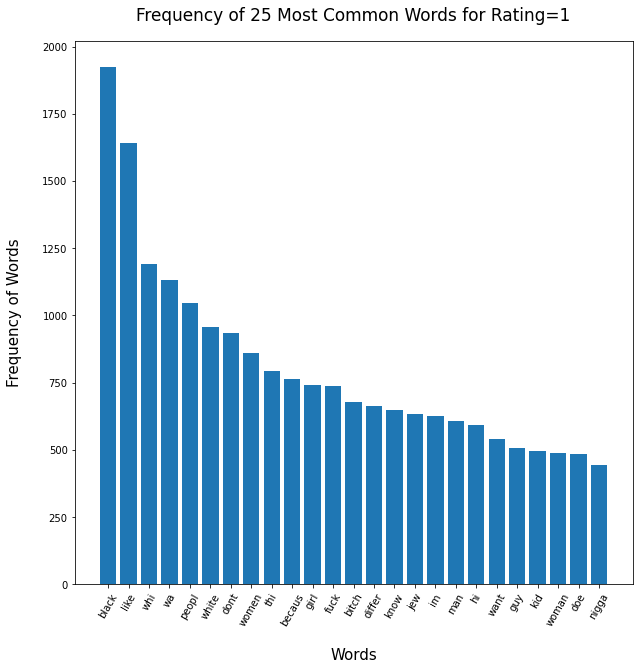

In [ ]:
group_by = df.groupby('hasBiasedImplication')['lemma_clean_str'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))
group_by_0 = group_by.iloc[0]


words0 = list(zip(*group_by_0))[0]
freq0 = list(zip(*group_by_0))[1]
plt.figure(figsize=(10, 10))
plt.bar(words0, freq0)
plt.xlabel('Words',fontsize =15, labelpad=20)
plt.ylabel('Frequency of Words', fontsize =15, labelpad=20)
plt.xticks(rotation=60)
plt.title('Frequency of 25 Most Common Words for Rating=1', fontsize =17, pad=20)
plt.show()

#### Apply Word2Vec to see most similar words learning from Model

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

model = Word2Vec(df['clean_post'], size=100, window=5, min_count=5, sg=1)

In [ ]:
pd.DataFrame(model.wv.most_similar('black'), columns=['Similar Words', 'Similarity'])

,Similar Words,Similarity
0,chain,0.847335
1,cop,0.841870
2,homeless,0.834119
3,indian,0.828520
4,mexican,0.827414
5,kkk,0.824909
6,bench,0.822745
7,hispan,0.820644
8,bike,0.819903
9,faster,0.816407


In [ ]:
def closestwords_tsneplot(model, word):
    '''
     bu sınıf verılen modelı ıle kelımeyı alır
     kelımeye en yakın kelımelerın vektorlerını bır dızıye atarız
     TSNE ıle bu vektorlerı grafıge donustururuz
    '''
    word_vectors = np.empty((0,100)) # en yakın olanları lısteyi hazırladık
    word_labels = [word] #kelımeyı dızı halıne getırdık
    
    close_words = model.wv.most_similar(word) #yakın olan kelımeler bulundu
    
    word_vectors = np.append(word_vectors, np.array([model.wv[word]]), axis=0) #gelen kelımenın vektoru eklendı
    
    for w, _ in close_words: #w kelimenın kendısı dıgerı ıse yakınlık oranı
        word_labels.append(w)
        word_vectors = np.append(word_vectors, np.array([model.wv[w]]), axis=0) #yakın kelımelerın vektorlerı de eklendı
        #boylece  gelen kelıme ve yakın kelımeler word_labels, bunların vektorlerı ise word_vectors akta
        
    tsne = TSNE(random_state=0) #kelımeleı grafıge doken kutuphane
    Y = tsne.fit_transform(word_vectors)
    
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    
    plt.scatter(x_coords, y_coords)
    
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(5, -2), textcoords='offset points')
        
    plt.show()

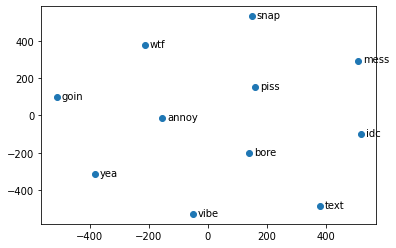

In [ ]:
closestwords_tsneplot(model, 'piss')

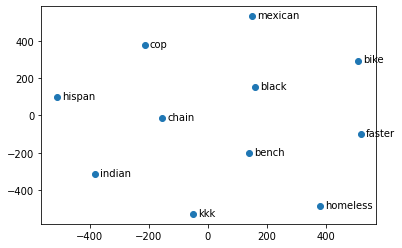

In [ ]:
closestwords_tsneplot(model, 'black')

#### Install and pull required packages for transformers

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 23.7 MB/s 
     |████████████████████████████████| 7.6 MB 62.7 MB/s 
     |████████████████████████████████| 182 kB 76.6 MB/s 


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
from torch import nn
from torch.optim import Adam
from transformers import GPT2Model, GPT2Tokenizer
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
# filtering the required columns
df_f = df[['post', 'hasBiasedImplication']]
df_o = df[['post', 'offensiveYN']]
df_c = df[['post', 'targetCategory']]

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

df_o.loc[df_o['offensiveYN'] >= 0.5, 'offensiveYN'] = 1
df_o.loc[df_o['offensiveYN'] < 0.5, 'offensiveYN'] = 0
df_o = df_o.astype({'offensiveYN': 'int32'})

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

#### DataRead

In [ ]:
class Dataset_c(torch.utils.data.Dataset):
    def __init__(self, df, labels_values, lable_column, data_column):
        if labels_values is None:
          self.labels = [label for label in df[lable_column]] # check
        else:
          self.labels = [labels_values[label] for label in df[lable_column]]
        self.texts = [tokenizer(text,
                                padding='max_length',
                                max_length=128,
                                truncation=True,
                                return_tensors="pt") for text in df[data_column]]
        
    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        # Get a batch of labels
        return np.array(self.labels[idx])
    
    def get_batch_texts(self, idx):
        # Get a batch of inputs
        return self.texts[idx]
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

In [ ]:
class SimpleGPT2SequenceClassifier(nn.Module):
    def __init__(self, hidden_size: int, num_classes:int ,max_seq_len:int, gpt_model_name:str):
        super(SimpleGPT2SequenceClassifier,self).__init__()
        self.gpt2model = GPT2Model.from_pretrained(gpt_model_name)
        self.fc1 = nn.Linear(hidden_size*max_seq_len, num_classes)

        
    def forward(self, input_id, mask):
        """
        Args:
                input_id: encoded inputs ids of sent.
        """
        gpt_out, _ = self.gpt2model(input_ids=input_id, attention_mask=mask, return_dict=False)
        batch_size = gpt_out.shape[0]
        linear_output = self.fc1(gpt_out.view(batch_size,-1))
        return linear_output

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):
    train, val = train_data, val_data
    
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    
    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        
        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)
            
            model.zero_grad()

            output = model(input_id, mask)
            
            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()
            
            acc = (output.argmax(dim=1)==train_label).sum().item()
            total_acc_train += acc

            batch_loss.backward()
            optimizer.step()
            
        total_acc_val = 0
        total_loss_val = 0
        
        with torch.no_grad():
            
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)
                
                output = model(input_id, mask)
                
                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()
                
                acc = (output.argmax(dim=1)==val_label).sum().item()
                total_acc_val += acc
                
            print(
            f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}")

In [ ]:
def evaluate(model, test_data):

    test = test_data

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

        
    # Tracking variables
    predictions_labels = []
    true_labels = []
    
    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
            
            # add original labels
            true_labels += test_label.cpu().numpy().flatten().tolist()
            # get predicitons to list
            predictions_labels += output.argmax(dim=1).cpu().numpy().flatten().tolist()
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return true_labels, predictions_labels

#### Split the offensive dataset

In [ ]:
# offensive or not
np.random.seed(112)
df_o_train, df_o_val, df_o_test = np.split(df_o.sample(frac=1, random_state=35), [int(0.8*len(df_o)), int(0.9*len(df_o))])

print(len(df_o_train), len(df_o_val), len(df_o_test))

categories = df_c['targetCategory'].unique()
labels_test = {}
for i, c in enumerate(categories):
  key, value = c, i
  labels_test[key] = value

# target category
df_c_train, df_c_val, df_c_test = np.split(df_c.sample(frac=1, random_state=35), [int(0.8*len(df_c)), int(0.9*len(df_c))])

print(len(df_c_train), len(df_c_val), len(df_c_test))



# bias or not
df_f_train, df_f_val, df_f_test = np.split(df_f.sample(frac=1, random_state=35), [int(0.8*len(df_f)), int(0.9*len(df_f))])

print(len(df_f_train), len(df_f_val), len(df_f_test))

28339 3542 3543
28339 3542 3543
28339 3542 3543


In [ ]:
df_o_train_1 = Dataset_c(df_o_train, None, 'offensiveYN', 'post')
df_o_val_1 = Dataset_c(df_o_val, None, 'offensiveYN', 'post')
df_o_test_1 = Dataset_c(df_o_test, None, 'offensiveYN', 'post')

df_c_train_1 = Dataset_c(df_c_train, labels_test, 'targetCategory', 'post')
df_c_val_1 = Dataset_c(df_c_val, labels_test, 'targetCategory', 'post')
df_c_test_1 = Dataset_c(df_c_test, labels_test, 'targetCategory', 'post')

df_f_train_1 = Dataset_c(df_f_train, None, 'hasBiasedImplication', 'post')
df_f_val_1 = Dataset_c(df_f_val, None, 'hasBiasedImplication', 'post')
df_f_test_1 = Dataset_c(df_f_test, None, 'hasBiasedImplication', 'post')

#### Train Offensive Classification Model

In [ ]:
EPOCHS = 1
model1 = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=2, max_seq_len=128, gpt_model_name="gpt2")
LR = 1e-5

train(model1, df_o_train_1, df_o_val_1, LR, EPOCHS)

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

100%|██████████| 14170/14170 [23:04<00:00, 10.23it/s]


Epochs: 1 | Train Loss:  0.251             | Train Accuracy:  0.758             | Val Loss:  0.215             | Val Accuracy:  0.803


In [ ]:
EPOCHS = 1
model2 = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=50, max_seq_len=128, gpt_model_name="gpt2")
LR = 1e-5

train(model2, df_c_train_1, df_c_val_1, LR, EPOCHS)

100%|██████████| 14170/14170 [23:30<00:00, 10.04it/s]


Epochs: 1 | Train Loss:  0.488             | Train Accuracy:  0.714             | Val Loss:  0.421             | Val Accuracy:  0.740


In [ ]:
EPOCHS = 1
model3 = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=2, max_seq_len=128, gpt_model_name="gpt2")
LR = 1e-5

train(model3, df_f_train_1, df_f_val_1, LR, EPOCHS)

100%|██████████| 14170/14170 [23:02<00:00, 10.25it/s]


Epochs: 1 | Train Loss:  0.242             | Train Accuracy:  0.766             | Val Loss:  0.209             | Val Accuracy:  0.797


#### Evaluate the Offensive Classification Model

In [ ]:
true_labels_o, pred_labels_o = evaluate(model1, df_o_test_1)


Test Accuracy:  0.797


In [ ]:
true_labels_c, pred_labels_c = evaluate(model2, df_c_test_1)

Test Accuracy:  0.740


In [ ]:
true_labels_f, pred_labels_f = evaluate(model3, df_f_test_1)

Test Accuracy:  0.795


### Save the model

In [ ]:
model_save_name = 'Offensive.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/models/{model_save_name}" 
torch.save(model1.state_dict(), path)

model_save_name = 'Category.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/models/{model_save_name}" 
torch.save(model2.state_dict(), path)

model_save_name = 'BiasImplication.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/models/{model_save_name}" 
torch.save(model3.state_dict(), path)


In [ ]:

"""# load trained model
model_new = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=2, max_seq_len=128, gpt_model_name="gpt2")
model_new.load_state_dict(torch.load("./gpt2-text-classifier-model.pt"))
model_new.eval()

example_text = """
Women always have to work more to get high pay when considred with men

"""
fixed_text = " ".join(example_text.lower().split())
print(fixed_text)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

model_input = tokenizer(fixed_text, padding='max_length', max_length=128, truncation=True, return_tensors="pt")

mask = model_input['attention_mask'].cpu()
input_id = model_input["input_ids"].squeeze(1).cpu()

output = model_new(input_id, mask)
prob = torch.nn.functional.softmax(output, dim=1)[0]

labels_map = {
      0: "not offensive",
      1: "offensive"
          }

pred_label = labels_map[output.argmax(dim=1).item()]
print(pred_label)"""

SyntaxError: ignored

In [ ]:
#torch.save(model1.state_dict(), "./gpt2-text-classifier-model.pt")

# load trained model


In [ ]:
"""labels_map_b = {
      0: "biased",
      1: "unbiased"
          }

labels_map_o = {
      0: "not offensive",
      1: "offensive"
          }

def predict_hasbiasornot(model, text, labels_map_v, model_path):

  model_new1 = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=2, max_seq_len=128, gpt_model_name="gpt2")
  model_new1.load_state_dict(torch.load(model_path))
  model_new1.eval()

  fixed_text = " ".join(text.lower().split())
  # tokenize the text
  tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
  tokenizer.padding_side = "left"
  tokenizer.pad_token = tokenizer.eos_token
  # create model input
  model_input = tokenizer(fixed_text, padding='max_length', max_length=128, truncation=True, return_tensors="pt")

  mask = model_input['attention_mask'].cpu()
  input_id = model_input["input_ids"].squeeze(1).cpu()

  output = model_new1(input_id, mask)
  prob = torch.nn.functional.softmax(output, dim=1)[0]

  labels_map = labels_map_v

  pred_label = labels_map[output.argmax(dim=1).item()]
  return pred_label"""

'labels_map_b = {\n      0: "biased",\n      1: "unbiased"\n          }\n\nlabels_map_o = {\n      0: "not offensive",\n      1: "offensive"\n          }\n\ndef predict_hasbiasornot(model, text, labels_map_v, model_path):\n\n  model_new1 = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=2, max_seq_len=128, gpt_model_name="gpt2")\n  model_new1.load_state_dict(torch.load(model_path))\n  model_new1.eval()\n\n  fixed_text = " ".join(text.lower().split())\n  # tokenize the text\n  tokenizer = GPT2Tokenizer.from_pretrained(\'gpt2\')\n  tokenizer.padding_side = "left"\n  tokenizer.pad_token = tokenizer.eos_token\n  # create model input\n  model_input = tokenizer(fixed_text, padding=\'max_length\', max_length=128, truncation=True, return_tensors="pt")\n\n  mask = model_input[\'attention_mask\'].cpu()\n  input_id = model_input["input_ids"].squeeze(1).cpu()\n\n  output = model_new1(input_id, mask)\n  prob = torch.nn.functional.softmax(output, dim=1)[0]\n\n  labels_map = labels_map_v\n\

In [ ]:
# text = """
# Women always have to work more to get high pay when considred with men

# """
# pred_o = predict_hasbiasornot(model1, text, labels_map_o, "./gpt2-text-classifier-model.pt")

In [ ]:
# with open("model_offensive_ornot.pkl", "wb") as f:
#   pickle.dump(model1, f)
# f.close()

In [ ]:
# with open("model_offensive_ornot.pkl", "rb") as f:
# 	model_new_load  = pickle.load(f)

In [ ]:
#!ls /content/gdrive/MyDrive/Colab\ Notebooks

In [ ]:
#!pip install gradio

In [ ]:
#import gradio as gr

In [ ]:
#predict_hasbiasornot('offensive.pt', "bad people", labels_map_o, "/content/gdrive/MyDrive/offensive.pt")

In [ ]:
# def greet_user(model_type, input_text):
#   if model_type == 'Offensive':
# 	  return predict_hasbiasornot(model1, input_text, labels_map_o, "/content/gdrive/MyDrive/")
#   if model_type == 'Category':
#     return 'Category'
#   if model_type == 'BiasImplication':
#     return 'BiasImplication'
 


In [ ]:
# #Create the input component for Gradio since we are expecting 4 inputs

# Model_type = gr.Textbox(label = "Enter the Model Type - Offensive, Category, BiasImplication")
# input_text = gr.Textbox(label = "Enter the Post/Comment/Tweet/Sentence")
# # We create the output
# output = gr.Textbox()


# app = gr.Interface(fn = greet_user, inputs=[Model_type, input_text], outputs=output)
# app.launch(share=True)